In [7]:
import os, sys
import numpy as np
import tensorflow as tf
import neurite as ne
import voxelmorph as vxm
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tensorflow.keras.layers as layers
from tensorflow import keras
from scripts.utils import *
from results.model import *
from scripts.rigid_transform import *
from scripts.loss import *
%load_ext autoreload
%autoreload 2

In [1]:
tf.config.list_physical_devices('GPU')

NameError: name 'tf' is not defined

# Load Data

In [3]:
def load_data(input_path):
    tot = len(os.listdir(input_path))
    data = np.zeros((tot,2,512,512))
    for i in range(tot):
        fix = Image.open(input_path+"/"+str(i)+"/0.jpg")
        moved = Image.open(input_path+"/"+str(i)+"/1.jpg")
        data[i][0] = np.asarray(fix)[:,:]/255
        data[i][1] = np.asarray(moved)[:,:]/255
    return data

In [4]:
data = load_data("data/mixed")
train = data[:-47]
test = data[-47:]

# Data Generator

In [10]:
def vxm_data_generator(data,batch_size=8):

    # preliminary sizing
    vol_shape = data.shape[2:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx = np.random.randint(0, data.shape[0], size=batch_size)
        fixed_images = data[idx, 0, ..., np.newaxis]
        moving_images = data[idx, 1, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

def save_results(images,path,name):
    if not os.path.isdir(path):
        os.mkdir(path)
    plt.imsave(path+"/"+name+"_"+str(0)+".png", images[1], cmap="gray")
    plt.imsave(path+"/"+name+"_"+str(1)+".png", images[0], cmap="gray")
    plt.imsave(path+"/"+name+"_"+str(2)+".png", images[2], cmap="gray")

# Import Model

In [6]:
# build model using VxmDense
inshape = (512,512)
nb_features = [
    [16, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16, 16]  # decoder features
]
new_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)

Instructions for updating:
Use fn_output_signature instead


In [7]:
new_model.load_weights("/EPFL/master/ML/ml-project-2/local_training/results/model/3h/weights");

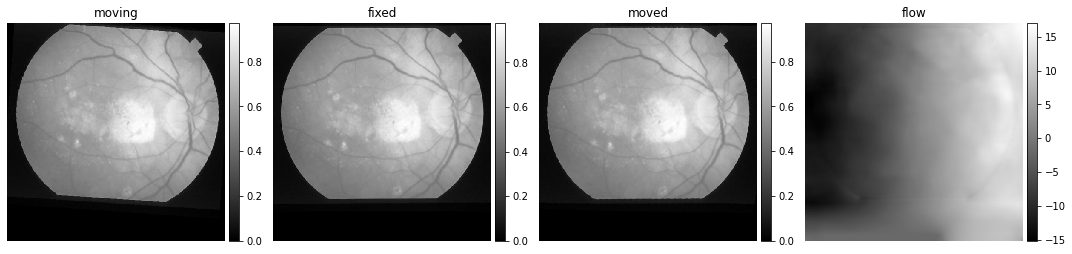

In [12]:
# let's get some data
val_generator = vxm_data_generator(test, batch_size = 1)
val_input, _ = next(val_generator)
val_pred = new_model.predict(val_input)

# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred] 
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [11]:
save_results(images,"/epfl/master/ml/ml-project-2/local_training/results/8","4")

# Import mask model

In [3]:
mask_model = keras.models.load_model("results/model/masks_200_epochs/mask_model.h5")

In [7]:
data = load_masks("data/mask/",target_size=(256,256))
train, test = split_dataset(data,balance=0.9,seed=120)
print(f"We have {train.shape[0]} training image pairs and {test.shape[0]} test image pairs.")

We have 2143 training image pairs and 239 test image pairs.


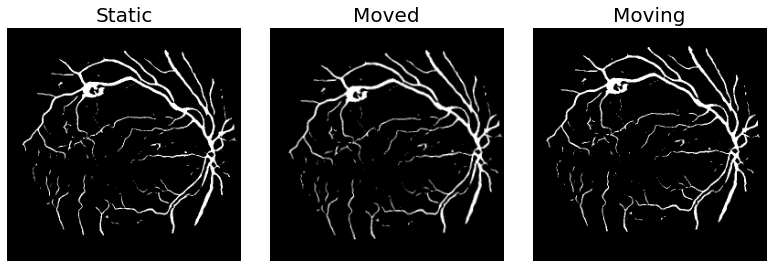

In [10]:
i = 101
plot_images(mask_model,test[i][1:],test[i][:1])

---